In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.set_printoptions(precision=6, linewidth=110)

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import uncertaintysampling as us

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(us)

import constants
imp.reload(constants)
from constants import *

# Construct surrogate in way that can be directly converted to lalsuite code

In [42]:
def kernel(x1, x2, hyperparams):
    """Matern covariance function for n-dimensional data.
    
    Parameters
    ----------
    x1 : array with shape ndim
    x2 : array with shape ndim
    hyperparams : array with shape ndim+2 [sigma_f, ls0, ls1, ..., sigma_n]
        sigma_f : Approximately the range (ymax-ymin) of values that the data takes.
            sigma_f^2 called the signal variance.
        sigma_n : Noise term. The uncertainty in the y values of the data.
        lsi : Length scales for the variation in dimension i.
    
    Returns
    -------
    covariance : float
    """
    sigma_f = hyperparams[0]
    sigma_n = hyperparams[-1]
    ls = hyperparams[1:-1]
    ndim = len(ls)
    
    # Noise nugget for diagonal elements
    if np.array_equal(x1, x2):
        nugget = sigma_n**2
    else:
        nugget = 0.0
    
    # r**2
    rsq = np.sum(np.array([(x1[i]-x2[i])**2 / ls[i]**2 for i in range(ndim)]))
    r = np.sqrt(rsq)
    
    # nu = 5/2 Matern covariance
    matern = (1. + np.sqrt(5.)*r + 5.*r**2/3.) * np.exp(-np.sqrt(5.)*r)
    
    # Full covariance
    # You must include the nugget to agree with scikit-learn when the points x1, x2 are exactly the same
    return sigma_f**2 * matern + nugget

In [43]:
def gp_predict(xst, hyperparams, x_train, Kinv_dot_y):
    """Interpolate the function at the point xst using Gaussian process regression.
    
    Parameters
    ----------
    xst : array of shape ndim.
        Point x_* where you want to evaluate the function.
    hyperparams : array with shape ndim+2 [sigma_f, ls0, ls1, ..., sigma_n].
        Hyperparameters for the GPR kernel.
    x_train : array of shape (n_train, ndim).
        Training set points.
    Kinv_dot_y : array of shape n_train.
        The interpolating weights at each training set point.
    
    Returns
    -------
    yst : float
        Interpolated value at the point xst.
    """
    # Evaluate vector K_*
    Kst = np.array([kernel(xst, x, hyperparams) for x in x_train])

    # Evaluate y_*
    return np.dot(Kst, Kinv_dot_y)

In [44]:
def extract_data_from_scikit_learn(gp):
    """Extract the data in the scikit-learn GaussianProcessRegressor class 
    that you need for the lalsuite version.
    """
    # hyperparams = np.array([sigma_f, lq, ls1, ls2, llam1, llam2, sigma_n])
    hyperparams = gpr.get_hyperparameters(gp)
    
    # The training data
    x_train = gp.X_train_
    y_train = gp.y_train_
    
    # Evaluate K
    K = np.array([[kernel(x1, x2, hyperparams) for x2 in x_train] for x1 in x_train])
    
    # Evaluate K^{-1}
    Kinv = np.linalg.inv(K)
    
    # Evaluate (K^{-1})_{ij} y_j (array of length nparams).
    Kinv_dot_y = np.dot(Kinv, y_train)
    
    return hyperparams, x_train, Kinv_dot_y

# Load scikit-learn (python) version of surrogate

In [45]:
Bamp_filename = '../../data/teobtest40hz/B_amp_corners_lhd.hdf5'
Bphase_filename = '../../data/teobtest40hz/B_phase_corners_lhd.hdf5'
gp_amp_filename = '../../data/teobtest40hz/gp_amp_corners_lhd.hdf5'
gp_phase_filename = '../../data/teobtest40hz/gp_phase_corners_lhd.hdf5'
sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, gp_amp_filename, gp_phase_filename)

# Bamp_filename = '../../data/teobtest40hz/B_amp_lhd_uncsamp.hdf5'
# Bphase_filename = '../../data/teobtest40hz/B_phase_lhd_uncsamp.hdf5'
# gp_amp_filename = '../../data/teobtest40hz/gp_amp_lhd_uncsamp.hdf5'
# gp_phase_filename = '../../data/teobtest40hz/gp_phase_lhd_uncsamp.hdf5'
# sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, gp_amp_filename, gp_phase_filename)

In [46]:
#Random point:
#x = np.array([0.8, 0.2, 0.1, 1000, 2000])

# Point exactly in training set:
x = np.array([3.333333e-01, -4.000000e-01, -4.000000e-01, 1.000000e-01, 1.000000e-01])

for i in range(len(sur.dphase_gp_list)):
    gp = sur.dphase_gp_list[i]
    #gp = sur.dphase_gp_list[0]
    hyperparams, x_train, Kinv_dot_y = extract_data_from_scikit_learn(gp)

    a = gp.predict(np.atleast_2d(x))[0]
    b = gp_predict(x, hyperparams, x_train, Kinv_dot_y)

    #sigma_n = hyperparams[-1]
    #print sigma_n
    print np.abs(b/a-1.)

5.53723478181e-09
6.42491049252e-09
1.96401661601e-09
5.68317459759e-09
4.66294558521e-09
2.28728636031e-09
2.02868855048e-09
2.36434094525e-10
1.48636081221e-09
2.49062059865e-09
4.93199625584e-09
1.76905234905e-09
3.07067204997e-09
1.08489428552e-09
4.44460579452e-10
2.02839578467e-09
3.19912274449e-09
3.97346355818e-09
1.37696076763e-09
3.79370002079e-09


In [ ]:
def save_gaussian_process_regression_list_for_lalsuite(filename, gp_list):
    """
    Save the information needed to reconstruct a list of
    GaussianProcessRegressor objects as an hdf5 file.
    Parameters
    ----------
    filename : string
        hdf5 filename
    gp_list : List of GaussianProcessRegressor objects
    """
    f = h5py.File(filename)

    ngp = len(gp_list)
    for i in range(ngp):
        # Create group for each GaussianProcessRegressor object
        groupname = 'gp_'+str(i)
        group = f.create_group(groupname)
        # write necessary data to reconstruct gp
        gp = gp_list[i]
        hyperparams, x_train, kinv_dot_y = extract_data_from_scikit_learn(gp)
        group['hyperparameters'] = hyperparams
        group['x_train'] = x_train_
        group['kinv_dot_y'] = kinv_dot_y

    f.close()

# Plot surrogate model

(<matplotlib.figure.Figure at 0x10d99d310>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x10e471490>,
  <matplotlib.axes._subplots.AxesSubplot at 0x10e5586d0>))

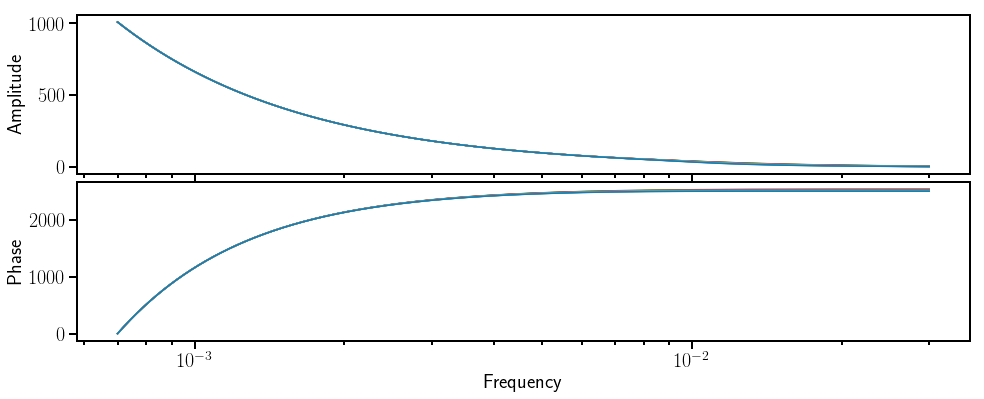

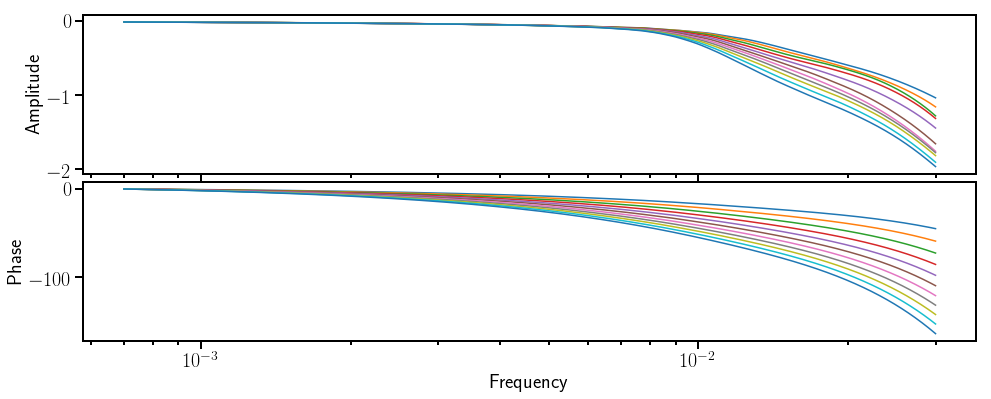

In [5]:
# Vary 1 parameters

q = 1.0
s1 = 0.3
s2 = 0.1
lambda1 = 1000.
lambda2 = 1000.
ps = np.array([[q, s1, s2, lambda1, lambda2] for lambda1 in np.linspace(0.1, 3000., 11)])

hs = [sur.geometric_waveform(p) for p in ps]
dhs = [sur.amp_phase_difference(p) for p in ps]

wave.plot_waveforms_fd(hs)
wave.plot_waveforms_fd(dhs)